# Business Problem

## A) Business Situation

(Kaggle description) Instead of waking to overlooked "Do not disturb" signs, Airbnb travelers find themselves rising with the birds min a whimsical treehouse, having their morning coffee on the deck of a houseboat, or cooking a shared regional breakfast with their hosts. New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

    -- Business Problem (open question): What's the target destination for the 1st booking of new users?

## B) Business Understanding

    -- Which business model Airbnb operates? 
        -- Marketplace - conect people which offer acomodation to people searching for it)
            -- Supply (people offering accomodation)
                -- Portfolio size
                -- Portfolio density
                -- Average price
                
            -- Demand (people seeking accomodation)
                -- Users quantity
                -- LTV (Lifetime value)
                -- CAC (customer acquisition cost)
            -- Gross Revenue = (Fee * Customer Qty) - CAC 
    
    -- Objective: 
        -- Predict the destination choice for new users (1st booking)
        -- Motivation: Antecipate new users choice in order to offer most assertive ads
        -- Root Cause: Increase gross revenue (through cheaper CAC)
        -- Scope (Closed afirmation)
        -- Stakeholder: CFO/CEO

#### Solution Planning

Solution Overview:
Kind problem: City destination prediction
Potential methods: Classification
Output: 
Steps:
Inputs:
    -- Solution proposal:
        -- Machine Learning model in order to predict 1st AirBnB destination
        -- API:
            -- Input: user + characteristics
            -- Output: user + characteristics + destination prediction



    -- C) Insights
    -- D) Business Results
    -- E) Conclusions (Objectives attained? Problem Solved?)
    -- F) Next Steps
    -- G) Lessons Learned


### Data Fields

Is given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA. There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

File descriptions
train_users.csv - the training set of users

test_users.csv - the test set of users

    -- id: user id
    -- date_account_created: the date of account creation
    --- timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
    -- date_first_booking: date of first booking
    -- gender
    -- age
    -- signup_method
    -- signup_flow: the page a user came to signup up from
    -- language: international language preference
    -- affiliate_channel: what kind of paid marketing
    -- affiliate_provider: where the marketing is e.g. google, craigslist, other
    -- first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
    -- signup_app
    -- first_device_type
    -- first_browser
    -- country_destination: this is the target variable you are to predict

sessions.csv - web sessions log for users
    -- user_id: to be joined with the column 'id' in users table
    -- action
    -- action_type
    -- action_detail
    -- device_type
    -- secs_elapsed

countries.csv - summary statistics of destination countries in this dataset and their locations

age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination

sample_submission.csv - correct format for submitting your predictions

# 0. Imports

In [244]:
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import OneHotEncoder
from sklearn.metrics         import accuracy_score,balanced_accuracy_score, cohen_kappa_score, classification_report, ConfusionMatrixDisplay

from keras import models as ml
from keras import layers as l

### 0.1 Helper Functions

### 0.2 Loading Data

In [245]:
df_raw = pd.read_csv('dataset/train_users.csv')
df_raw.shape
print('The train_users dataset contains {} columns and {} rows'.format(df_raw.shape[1], df_raw.shape[0]))

The train_users dataset contains 16 columns and 213451 rows


In [246]:
df_sessions = pd.read_csv('dataset/sessions.csv')
df_sessions.shape
print('The sessions dataset contains {} columns and {} rows'.format(df_sessions.shape[1], df_sessions.shape[0]))

The sessions dataset contains 6 columns and 10567737 rows


# 1. Data Description

In [247]:
df1 = df_raw.copy()

## 1.1 NAs Check 

In [248]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

### 1.1.1 Removing NAs

In [249]:
#for the 1st cycle we will drop NAs - 1st cycle aims to prepare the entire pipeline
df1 = df1.dropna()

## 1.2 Data Type

In [250]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

### 1.2.1 Change Data Types 

In [251]:
#date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])
#timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')
#date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])
#age
df1['age'] = df1['age'].astype(int)

In [252]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.3 Check balanced data

In [253]:
df1['country_destination'].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 2.0 Data Filtering - Business knowledge

In [254]:
#Filtering based on business assumptions and rules
df2 = df1.copy()

## Rows filtering

## Columns selection

# 3.0 Data Preparation

In [255]:
#split dataset training/validation
X = df2.drop(columns='country_destination')
y = df2['country_destination'].copy()

In [256]:
X.drop(columns='id',axis=1, inplace=True)

aux= pd.get_dummies(X)

X = pd.concat([df2['id'],aux],axis=1)

In [257]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=32)

# 4.0 Feature Selection

In [258]:
cols_drop = ['id','date_account_created', 'timestamp_first_active', 'date_first_booking']
X_train = X_train.drop(cols_drop, axis=1)
X_val = X_val.drop(cols_drop, axis=1)

# 5.0 ML Modeling

### Baseline Model

In [259]:
country_dest_list

['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'US', 'other']

In [260]:
df2['country_destination'].value_counts(normalize=True).sort_index().to_list()

[0.00636634345982896,
 0.01569582373736633,
 0.012453976030863564,
 0.024863945079285913,
 0.05408458142025201,
 0.02593478165202212,
 0.02976338912440774,
 0.008801396488242802,
 0.002317701075237271,
 0.7088644731630752,
 0.11085358876941809]

In [261]:
#build a random model - baseline

#values to pick ramdomly
country_dest_list = sorted(df2['country_destination'].unique())

#classes presence
target_weights = df2['country_destination'].value_counts(normalize=True).sort_index().to_list()

#size 
k_num = y_val.shape[0]

yhat_baseline = random.choices(population=country_dest_list, weights=target_weights, k=k_num)

Accuracy 0.5239457279061239
 Balanced Accuracy 0.09464521945684216
 Kappa score 0.00837425799873237
              precision    recall  f1-score   support

          AU       0.02      0.02      0.02       101
          CA       0.01      0.01      0.01       214
          DE       0.02      0.02      0.02       170
          ES       0.02      0.02      0.02       345
          FR       0.06      0.06      0.06       710
          GB       0.04      0.04      0.04       344
          IT       0.03      0.03      0.03       423
          NL       0.01      0.01      0.01       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.72      0.71      9624
       other       0.11      0.11      0.11      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.52      0.52      0.52     13635



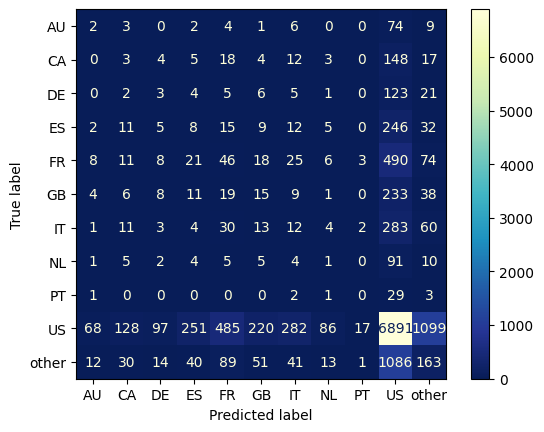

In [262]:
#acuracy
acc_base = accuracy_score(y_val, yhat_baseline)
print('Accuracy {}'.format(acc_base))

#balanced accuracy
balanced_acc_base = balanced_accuracy_score(y_val, yhat_baseline)
print(' Balanced Accuracy {}'.format(balanced_acc_base))

#Kappa score - estimators agreement
kappa_base = cohen_kappa_score(y_val, yhat_baseline)
print(' Kappa score {}'.format(kappa_base))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, yhat_baseline, cmap='YlGnBu_r');

#classification report
print(classification_report(y_val, yhat_baseline))

### 5.2 Neural Network MLP 

In [263]:
ohe = OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [264]:
#model definition
model = ml.Sequential()
#1st layer
model.add(l.Dense(128, input_dim=X_train.shape[1], activation='relu'))
#output layer
model.add(l.Dense(11, activation='softmax'))
          
#model compile
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
          
#train model
model.fit(X_train,y_train_nn, epochs=100)

#prediction
pred_nn = model.predict(X_val)

#invert prediction
yhat_nn = ohe.inverse_transform(pred_nn) 

#prediction prepare
y_val_nn = y_val.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

Epoch 1/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.3556 - accuracy: 0.7038
Epoch 2/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2757 - accuracy: 0.7074
Epoch 3/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2554 - accuracy: 0.7076
Epoch 4/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2235 - accuracy: 0.7085
Epoch 5/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2003 - accuracy: 0.7085
Epoch 6/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1859 - accuracy: 0.7085
Epoch 7/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1759 - accuracy: 0.7087
Epoch 8/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1629 - accuracy: 0.7087
Epoch 9/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1546 - accuracy: 0.7086
Epoch 10/100
1705/1705 [==============================] - 4s 2ms/step - l

1705/1705 [==============================] - 3s 2ms/step - loss: 1.1021 - accuracy: 0.7116
Epoch 80/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1018 - accuracy: 0.7114
Epoch 81/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1015 - accuracy: 0.7114
Epoch 82/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1009 - accuracy: 0.7116
Epoch 83/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1015 - accuracy: 0.7116
Epoch 84/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1008 - accuracy: 0.7119
Epoch 85/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1007 - accuracy: 0.7117
Epoch 86/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1009 - accuracy: 0.7116
Epoch 87/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1002 - accuracy: 0.7120
Epoch 88/100
1705/1705 [==============================] - 3s 2ms/step - loss:

### 5.2.1 NN Performance

Accuracy 0.7029702970297029
 Balanced Accuracy 0.0917361751903703
 Kappa score 0.00188955370441235
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.25      0.01      0.01       170
          ES       0.17      0.00      0.01       345
          FR       0.20      0.00      0.00       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.14      0.00      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.13      0.09      0.08     13635
weighted avg       0.53      0.70      0.58     13635



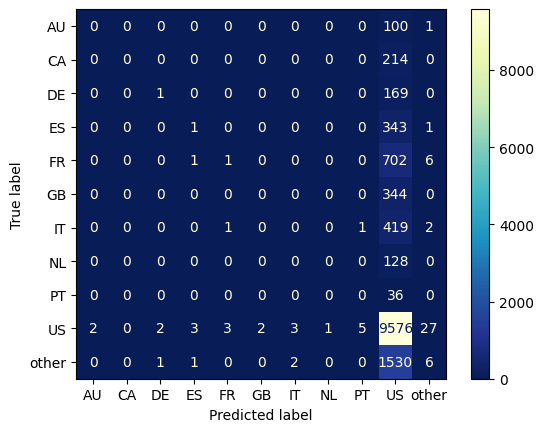

In [265]:
#acuracy
acc_nn = accuracy_score(y_val_nn, yhat_nn)
print('Accuracy {}'.format(acc_nn))

#balanced accuracy
balanced_acc_nn = balanced_accuracy_score(y_val_nn, yhat_nn)
print(' Balanced Accuracy {}'.format(balanced_acc_nn))

#Kappa score - estimators agreement
kappa = cohen_kappa_score(y_val_nn, yhat_nn)
print(' Kappa score {}'.format(kappa))

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val_nn, yhat_nn, cmap='YlGnBu_r');

#classification report
print(classification_report(y_val_nn, yhat_nn))

### 5.2.1 NN Performance - Cross validation

In [266]:
#generate k-fold
n_folds=5
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True,random_state=32)
balanced_acc_list = []
kappa_list = []
i=1

for train_ix, val_ix in kfold.split(X_train, y_train):

    print('Fold {}/{}'.format(i,n_folds))
    
    #define fold
    X_train_cv = X_train.iloc[train_ix]
    y_train_cv = y_train.iloc[train_ix]

    X_val_cv = X_train.iloc[val_ix]
    y_val_cv = y_train.iloc[val_ix]


    #target one-hot encoding
    ohe = OneHotEncoder()
    y_train_cv_nn = ohe.fit_transform(y_train_cv.values.reshape(-1,1)).toarray()
    
    
    #model definition
    model = ml.Sequential()
    model.add(l.Dense( 128, input_dim=X_train_cv.shape[1], activation='relu'))
    model.add(l.Dense(11, activation='softmax' ))

    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    #training model
    model.fit(X_train_cv, y_train_cv_nn, epochs=100, batch_size=32, verbose=0)

    #prediction
    pred_nn_cv = model.predict(X_val_cv)
    yhat_nn_cv = ohe.inverse_transform(pred_nn_cv)
    
    y_val_nn_cv = y_val_cv.to_numpy()
    yhat_nn_cv = yhat_nn_cv.reshape(1,-1)[0]
    
    #balanced accuracy
    balanced_acc_nn = balanced_accuracy_score(y_val_nn_cv, yhat_nn_cv)
    balanced_acc_list.append(balanced_acc_nn)
    
    #Kappa score - estimators agreement
    kappa = cohen_kappa_score(y_val_nn_cv, yhat_nn_cv)
    kappa_list.append(kappa)
    
    i+=1


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [267]:
print('Balanced Accuracy after {} K-Folds CV is {} ± {}'.format(n_folds, np.round(np.mean(balanced_acc_list),2), 
                                                                         np.round(np.std(balanced_acc_list),4)))
print('Kappa Score after {} K-Folds CV is {} ± {}'.format(n_folds, np.round(np.mean(kappa_list),4), 
                                                                         np.round(np.std(kappa_list),4)))

Balanced Accuracy after 5 K-Folds CV is 0.09 ± 0.0004
Kappa Score after 5 K-Folds CV is 0.0035 ± 0.0025
